# Optimierung

Testing and visualizing low-level optimization techniques.

- [**Cache-Based Optimization**](#cache)
  - [**Cache-Obliviousness**](#oblivious)
  - [**False Sharing**](#falsesharing)
- [**Number Representation**](#nr)
  - [**C++ Basic Types**](#cpptypes)

In [1]:
import matplotlib.pyplot as plt
from utils import compile, execute, decompose_results, read_lines

<a id='cache'></a>

## Cache-Based Optimization Techniques

A CPU cache is a low-latency hardware component directly attached to a CPU. When the CPU accesses
data from main memory, it writes them into the cache. When the CPU needs to access main memory
again, it first checks if the data are already in the cache. It's that the case, it retrieves data
from the cache instead of using high-latency main memory. This is called a cache hit. It accelerates
programs because the CPU does not have to waste clock cycles waiting for data to arrive from main
memory.

We can accelerate programs by writing them in a way that maximizes cache hits to reduce the time
waiting for data from main memory. The key for that is the **principle of locality**. We want to use
the data in the cache before accessing the main memory again, and that can be accomplished by
accessing data that sit in the same block of memory.

An algorithm is called **cache-aware** if it is optimized by knowing the size of the cache. It is
called **cache-oblivious** if it is optimized for the cache regardless of its size. The thesis
https://ocw.mit.edu/courses/6-895-theory-of-parallel-systems-sma-5509-fall-2003/6dc7de52dcf13b53cebf2fe10ae6752a_cach_oblvs_thsis.pdf
explains it in detail.

<a id='oblivious'></a>

### Cache-Oblivious Matrix Multiplication

Matrix multiplication is really "baby's first cache optimization". We can accelerate a naïve matrix
multiplication by transposing the right-hand matrix and access its rows instead of columns, which
results in fewer cache misses. But a truly cache-oblivious algorithm can be achieved by recursively
performing multiplication and additions.

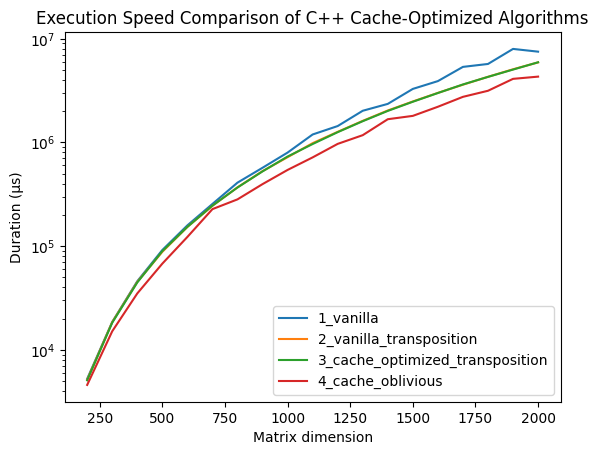

In [52]:
executable = compile("cache/matrix_multiplication")
output = execute(executable)
N, result = decompose_results(output)

fig, ax = plt.subplots()
for technique in result:
    ax.plot(N, result[technique], label=f"{technique}")
ax.set(xlabel='Matrix dimension', ylabel='Duration (μs)')
ax.set_yscale('log')
ax.legend()
ax.set_title("Execution Speed Comparison of C++ Cache-Optimized Algorithms")
plt.show()

Notice:

- The naïve implementation (`1_vanilla`) is the slowest one because of all the cache misses.
- Transposition (`2_vanilla_transposition`) accelerates computations.
- Cache-oblivious transposition (`3_cache_optimized_transposition`) does not provide much benefit
  compared to naïve transposition. It should be faster in theory because it reduces cache misses,
  but the compiler probably has an easier time optimizing the simpler version, which makes it faster
  in practice.
- Cache-oblivious matrix multiplication (`4_cache_oblivious`) is faster because it basically
  combines transposition and multiplication / addition, which reduces cache misses even further.

In [55]:
A = result["1_vanilla"][-1]
B = result["2_vanilla_transposition"][-1]
D = result["4_cache_oblivious"][-1]
print(f"The transposition-based algorithm completed in {B / A * 100:.5} % of the time taken by the naïve implementation.")
print(f"The cache-oblivious algorithm completed in {D / A * 100:.5} % of the time taken by the naïve implementation.")

The transposition-based algorithm completed in 78.828 % of the time taken by the naïve implementation.
The cache-oblivious algorithm completed in 57.482 % of the time taken by the naïve implementation.


Would that work in Python?

The transposition-based algorithm completed in 85.967 % of the time taken by the naïve implementation.


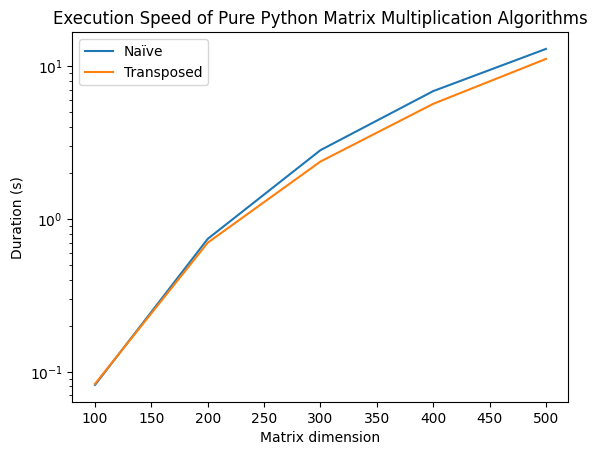

In [5]:
from random import uniform
from time import time


def create_matrix(size: int) -> list[list[float]]:
    return [[uniform(-1.0, 1.0) for _ in range(size)] for _ in range(size)]


def naive_matmul(A, B, C):
    N = len(A)
    for i in range(N):
        for j in range(N):
            C[i][j] = 0.0
            for k in range(N):
                C[i][j] += A[i][k] * B[k][j]


def transpose_matmul(A, B, C):
    N = len(A)

    def transpose(M: list[list[float]]):
        for i in range(N):
            for j in range(i):
                tmp = M[i][j]
                M[i][j] = M[j][i]
                M[j][i] = tmp

    transpose(B)
    for i in range(N):
        for j in range(N):
            C[i][j] = 0.0
            for k in range(N):
                C[i][j] += A[i][k] * B[j][k]


naive_durations = []
transpose_durations = []
N = range(100, 600, 100)
for n in N:
    A = create_matrix(n)
    B = create_matrix(n)
    C = [[0 for _ in range(n)] for _ in range(n)]
    a = time()
    naive_matmul(A, B, C)
    b = time()
    transpose_matmul(A, B, C)
    c = time()
    naive_durations.append(b - a)
    transpose_durations.append(c - b)

A = naive_durations[-1]
B = transpose_durations[-1]
print(f"The transposition-based algorithm completed in {B / A * 100:.5} % of the time taken by the naïve implementation.")
fig, ax = plt.subplots()
ax.plot(list(N), naive_durations, label="Naïve")
ax.plot(list(N), transpose_durations, label="Transposed")
ax.set(xlabel='Matrix dimension', ylabel='Duration (s)')
ax.set_yscale('log')
ax.legend()
ax.set_title("Execution Speed of Pure Python Matrix Multiplication Algorithms")
plt.show()

Optimizing for the cache **may** lead to a performance gain in pure Python, but it can be smaller
than in C++ or even *decrease performance* because Python lists are more abstracted than C++ vectors:

- C++ vectors or arrays are stored in contiguous locations, so row indexing is much more
  cache-friendly than accessing columns.
- Python lists contain pointers to Python Objects. The pointers are contiguous in memory, but they
  may point at arbitrary memory locations. So iterating over rows is faster than iterating over
  columns because the pointers are stored in a cache-friendly way, but fetching the *values* pointed
  by pointers not necessarily is. It's actually not cache-friendly at all if the memory allocator
  places the values at random locations, but if the allocator places them at contiguous locations,
  we may benefit from cache optimization. Unfortunately, we cannot directly control the memory
  allocator.

Of course, it's much simpler to use a library dedicated to linear algebra like BLAS or Numpy to
perform that kind of operation because they implement cache optimization (and other optimizations!)
out of the box. But in some programs, modifying the code in non-obvious ways to promote data
locality may improve performance through cache optimization.

<a id='falsesharing'></a>

### False Sharing

This is not an optimization technique, but rather a problem to avoid because it can decrease the
performance of a program. Most of the time, when a thread writes into the main memory, the entire
cache block is written across a range of addresses in the main memory. If two threads are trying to
write into this range of addresses *at the same time*, their cache blocks have to wait for their
turn to write, which causes delays.

The following cell executes a simple C++ programs that sums the elements in an array of real
numbers. The vector is divided in subvectors that get added up by threads in parallel. The
threads write their respective sum in an intermediate result vector. The final sum is computed by
adding up the values in the intermediate vector. If the threads write into memory locations that are
very close in the intermediate result vector, we might observe false sharing because the threads
"compete" to write into main memory (of course, false sharing because a noticeable phenomenon only
when the threads frequently write into main memory, this is just to illustrate).

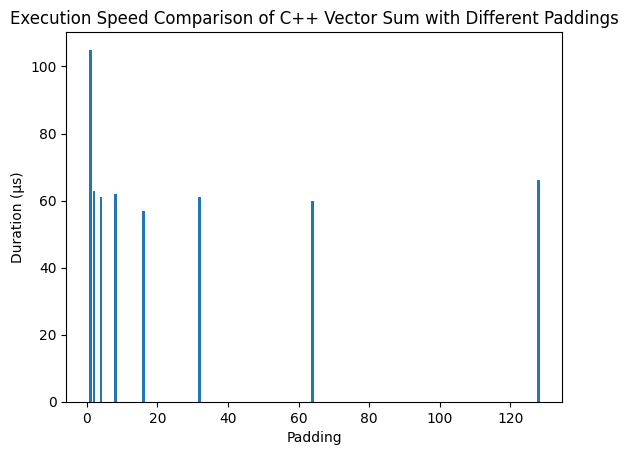

In [17]:
executable = compile("cache/false_sharing")
output = execute(executable)
result = decompose_results(output)

fig, ax = plt.subplots()
ax.bar(result[0], result[1]["Duration"])
ax.set(xlabel='Padding', ylabel='Duration (μs)')
ax.set_title("Execution Speed Comparison of C++ Vector Sum with Different Paddings")
plt.show()

Using two contiguous memory locations in the intermediate result vector (i.e. using a padding of 1)
results in false sharing. Simply padding the memory locations in the vector improves performance.

<a id='nr'></a>

## Number Representation

Let's see how to optimize a program by selecting the most appropriate representation of numbers.

<a id='cpptypes'></a>

### C++ Basic Types

Let's compare the performance of C++ types for different operations:

Text(0.5, 0.98, 'Execution Speed Comparison of C++ Types for Different Operations')

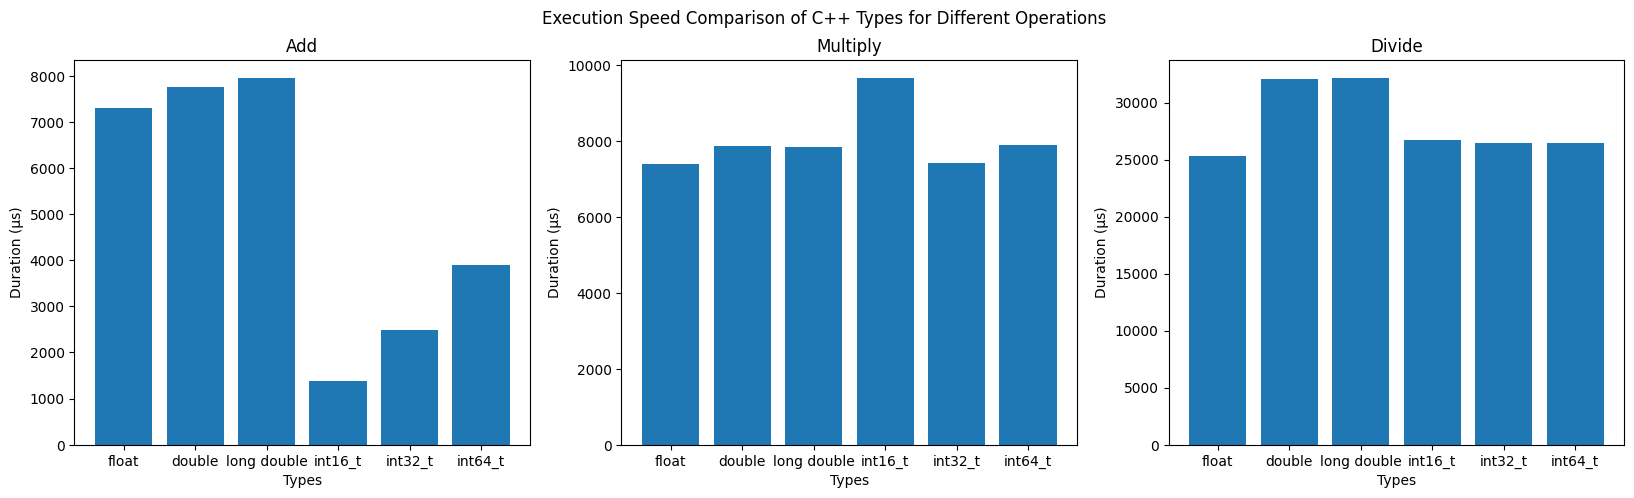

In [22]:
executable = compile("number_representation/cpp_types")
output = execute(executable)
result = read_lines(output)[1:]  # Remove the header.

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(20, 5)
for i, operation in enumerate(("Add", "Multiply", "Divide")):
    lines = [r for r in result if r[1] == operation]
    names = [c[0] for c in lines]
    durations = [float(c[2]) for c in lines]
    ax[i].bar(names, durations, label=names)
    ax[i].title.set_text(operation)
    ax[i].set(xlabel='Types', ylabel='Duration (μs)')
fig.suptitle("Execution Speed Comparison of C++ Types for Different Operations")

A few remarks:

- For **additions**, integer types are faster. Also, the smaller a type is, the faster it is.
  - This is because addition is a very simply operation that get optimized easily. Adding up
    integers is simpler for the hardware than adding real numbers.
  - A lot of the discrepancies in execution speeds can be attributed to the cache. `int16_t` are
    easier to shove in the cache because they take up just two octets, which leads to fewer cache
    misses.
- For **multiplications**, all types offer similar performance *except* for `int16_t`, the smallest
  type here.
  - That's because multiplication is more complex than addition, so the simpler representation of
    integers is not really better than real numbers.
  - `int16_t` offering the worst performance on my system is probably because it gets converted to
    another representation (e.g. `int32_t`) before the operation.
- For **divisions**, performance is relatively uniform except for `double` and `long double`, which
  are slower.
  - That makers sense, they use more bytes.
  - Integer types are not really better than `float` for divisions.

Takeaway:

- If your program uses simple operations like additions, subtractions, bitwise operations, or
  logical operators, integer types are more efficient. If the range of numbers allows it, you can
  further improve performance by using smaller number representations like `int16_t` or even
  `int8_t`. But watch out for overflows!
- If your program uses "complex" mathematical operations like division, multiplication, or
  exponentiation, real numbers are generally better because they offer more precision and
  flexibility and end up with similar or even better performance than integer types.